# Starbucks Capstone Challenge

## Introduction
The datasets contain simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). The project represents a one-month experiment for Starbucks to test out the market and see what offers really excite different demographics of people.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, r2_score, plot_roc_curve
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
plt.style.use('seaborn-dark')

In [35]:
customers = pd.read_csv('cleaned_data/imputed_customers.csv')
X = customers[['gender','age','income','membership_years','weekly_transactions','weekly_amount_spent']]
X = pd.get_dummies(X, drop_first=True)
features = X.columns
X.head()

,age,income,membership_years,weekly_transactions,weekly_amount_spent,gender_M
0,55.0,112000.0,1.030137,0.75,19.2525,0
1,75.0,100000.0,1.213699,1.75,39.8175,0
2,68.0,70000.0,0.249315,0.75,14.4325,1
3,65.0,53000.0,0.457534,0.75,9.1075,1
4,58.0,51000.0,0.704110,1.00,3.9050,1


In [29]:
# X = pd.get_dummies(customers.drop(['id','became_member_on','demographic'],axis=1))
# features = X.columns
# X.head()

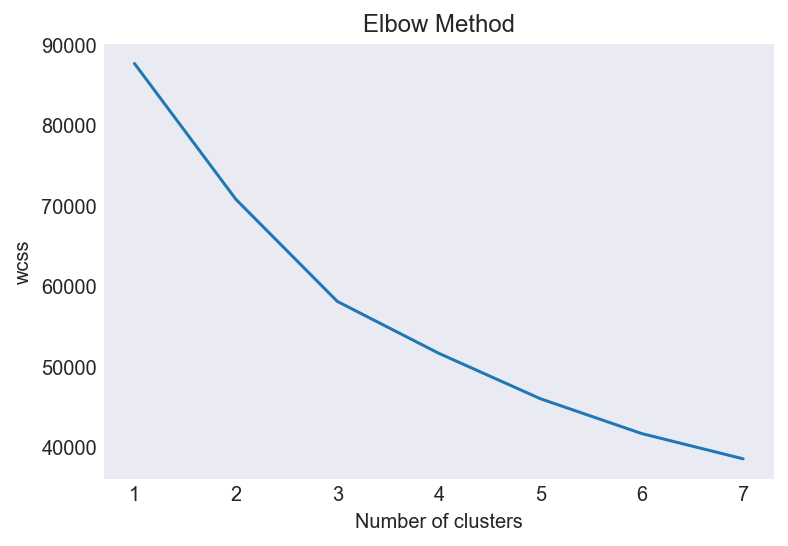

In [36]:
# Scale X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use the elbow method
wcss = []
for i in range(1,8):
    km = KMeans(n_clusters=i)
    km.fit(X_scaled)
    wcss.append(km.inertia_)
plt.plot(range(1,8),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

In [39]:
# Kmeans algorithm
kmeans = KMeans(n_clusters=4, random_state=42)

# Fit and predict 
y_means = kmeans.fit_predict(X_scaled)
X['cluster'] = y_means
customers['cluster'] = y_means

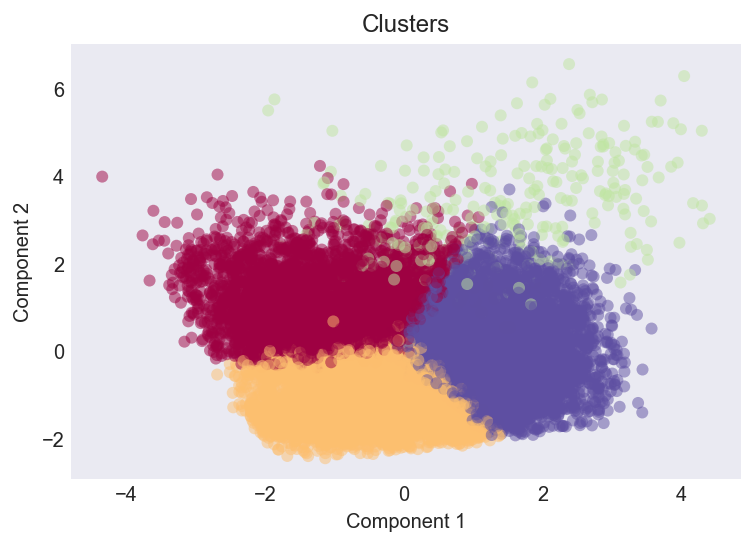

In [40]:
# Apply PCA and fit the features selected
pca = PCA(n_components=2).fit(X_scaled)

# Transform samples using the PCA fit
pca_2d = pca.transform(X_scaled)

# fig, ax = plt.subplots(figsize = (8, 6))
plt.scatter(pca_2d[:, 0], pca_2d[:, 1],
            c=y_means, 
            edgecolor="none",
            cmap=plt.cm.get_cmap("Spectral_r", 4),
            alpha=0.5)

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('Clusters')
plt.show()

In [41]:
# Create a melted customer data for visualization
customers_scaled = pd.DataFrame(X_scaled, columns=features)
customers_scaled['cluster'] = y_means

customers_melt = customers_scaled.melt(id_vars='cluster', value_vars=features)
customers_melt.sample(5)

,cluster,variable,value
86296,2,gender_M,0.849725
54014,0,weekly_transactions,-0.841867
60761,3,weekly_amount_spent,0.286274
73445,0,gender_M,-1.176852
61716,3,weekly_amount_spent,0.007644


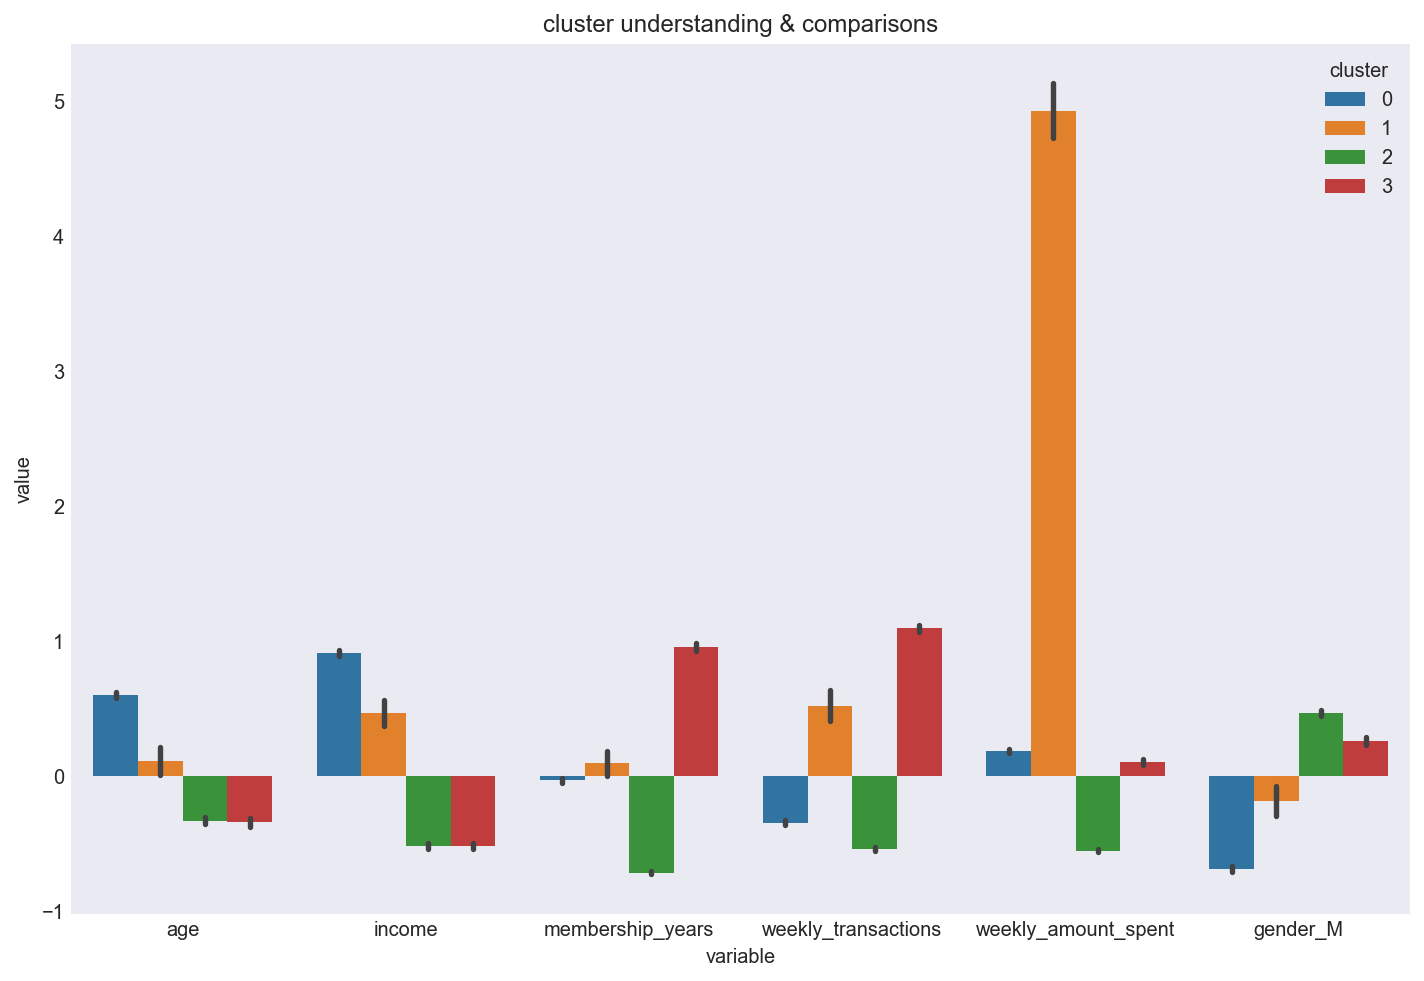

In [88]:
# Visualization the features for different clusters
# The clusters make business sense
plt.figure(figsize=(12,8))
sns.barplot(data=customers_melt, x='variable', y='value', hue='cluster')
plt.title('cluster understanding & comparisons')
plt.show()

In [66]:
cluster_responses = customers.drop(['age','income','membership_years','became_member_on','id',
                                   'gender','weekly_transactions','weekly_amount_spent','demographic'],axis=1)
cluster_responses = cluster_responses.groupby('cluster').mean().T
cluster_responses

cluster,0,1,2,3
responded,0.911050,0.973684,0.579300,0.921354
invalid_responded,0.018383,0.009868,0.008800,0.007466
responded_bogo_5_7_5_web_email_mobile,0.191144,0.226974,0.106562,0.186660
invalid_responded_bogo_5_7_5_web_email_mobile,0.095869,0.088816,0.057394,0.102041
responded_discount_20_10_5_web_email,0.127100,0.174342,0.056246,0.106023
invalid_responded_discount_20_10_5_web_email,0.146274,0.164474,0.037689,0.121951
responded_discount_10_7_2_web_email_mobile,0.189365,0.259868,0.090109,0.194873
invalid_responded_discount_10_7_2_web_email_mobile,0.092113,0.078947,0.039793,0.085366
responded_discount_10_10_2_web_email_mobile_social,0.307373,0.411184,0.171609,0.379044
invalid_responded_discount_10_10_2_web_email_mobile_social,0.007314,0.006579,0.004400,0.007964


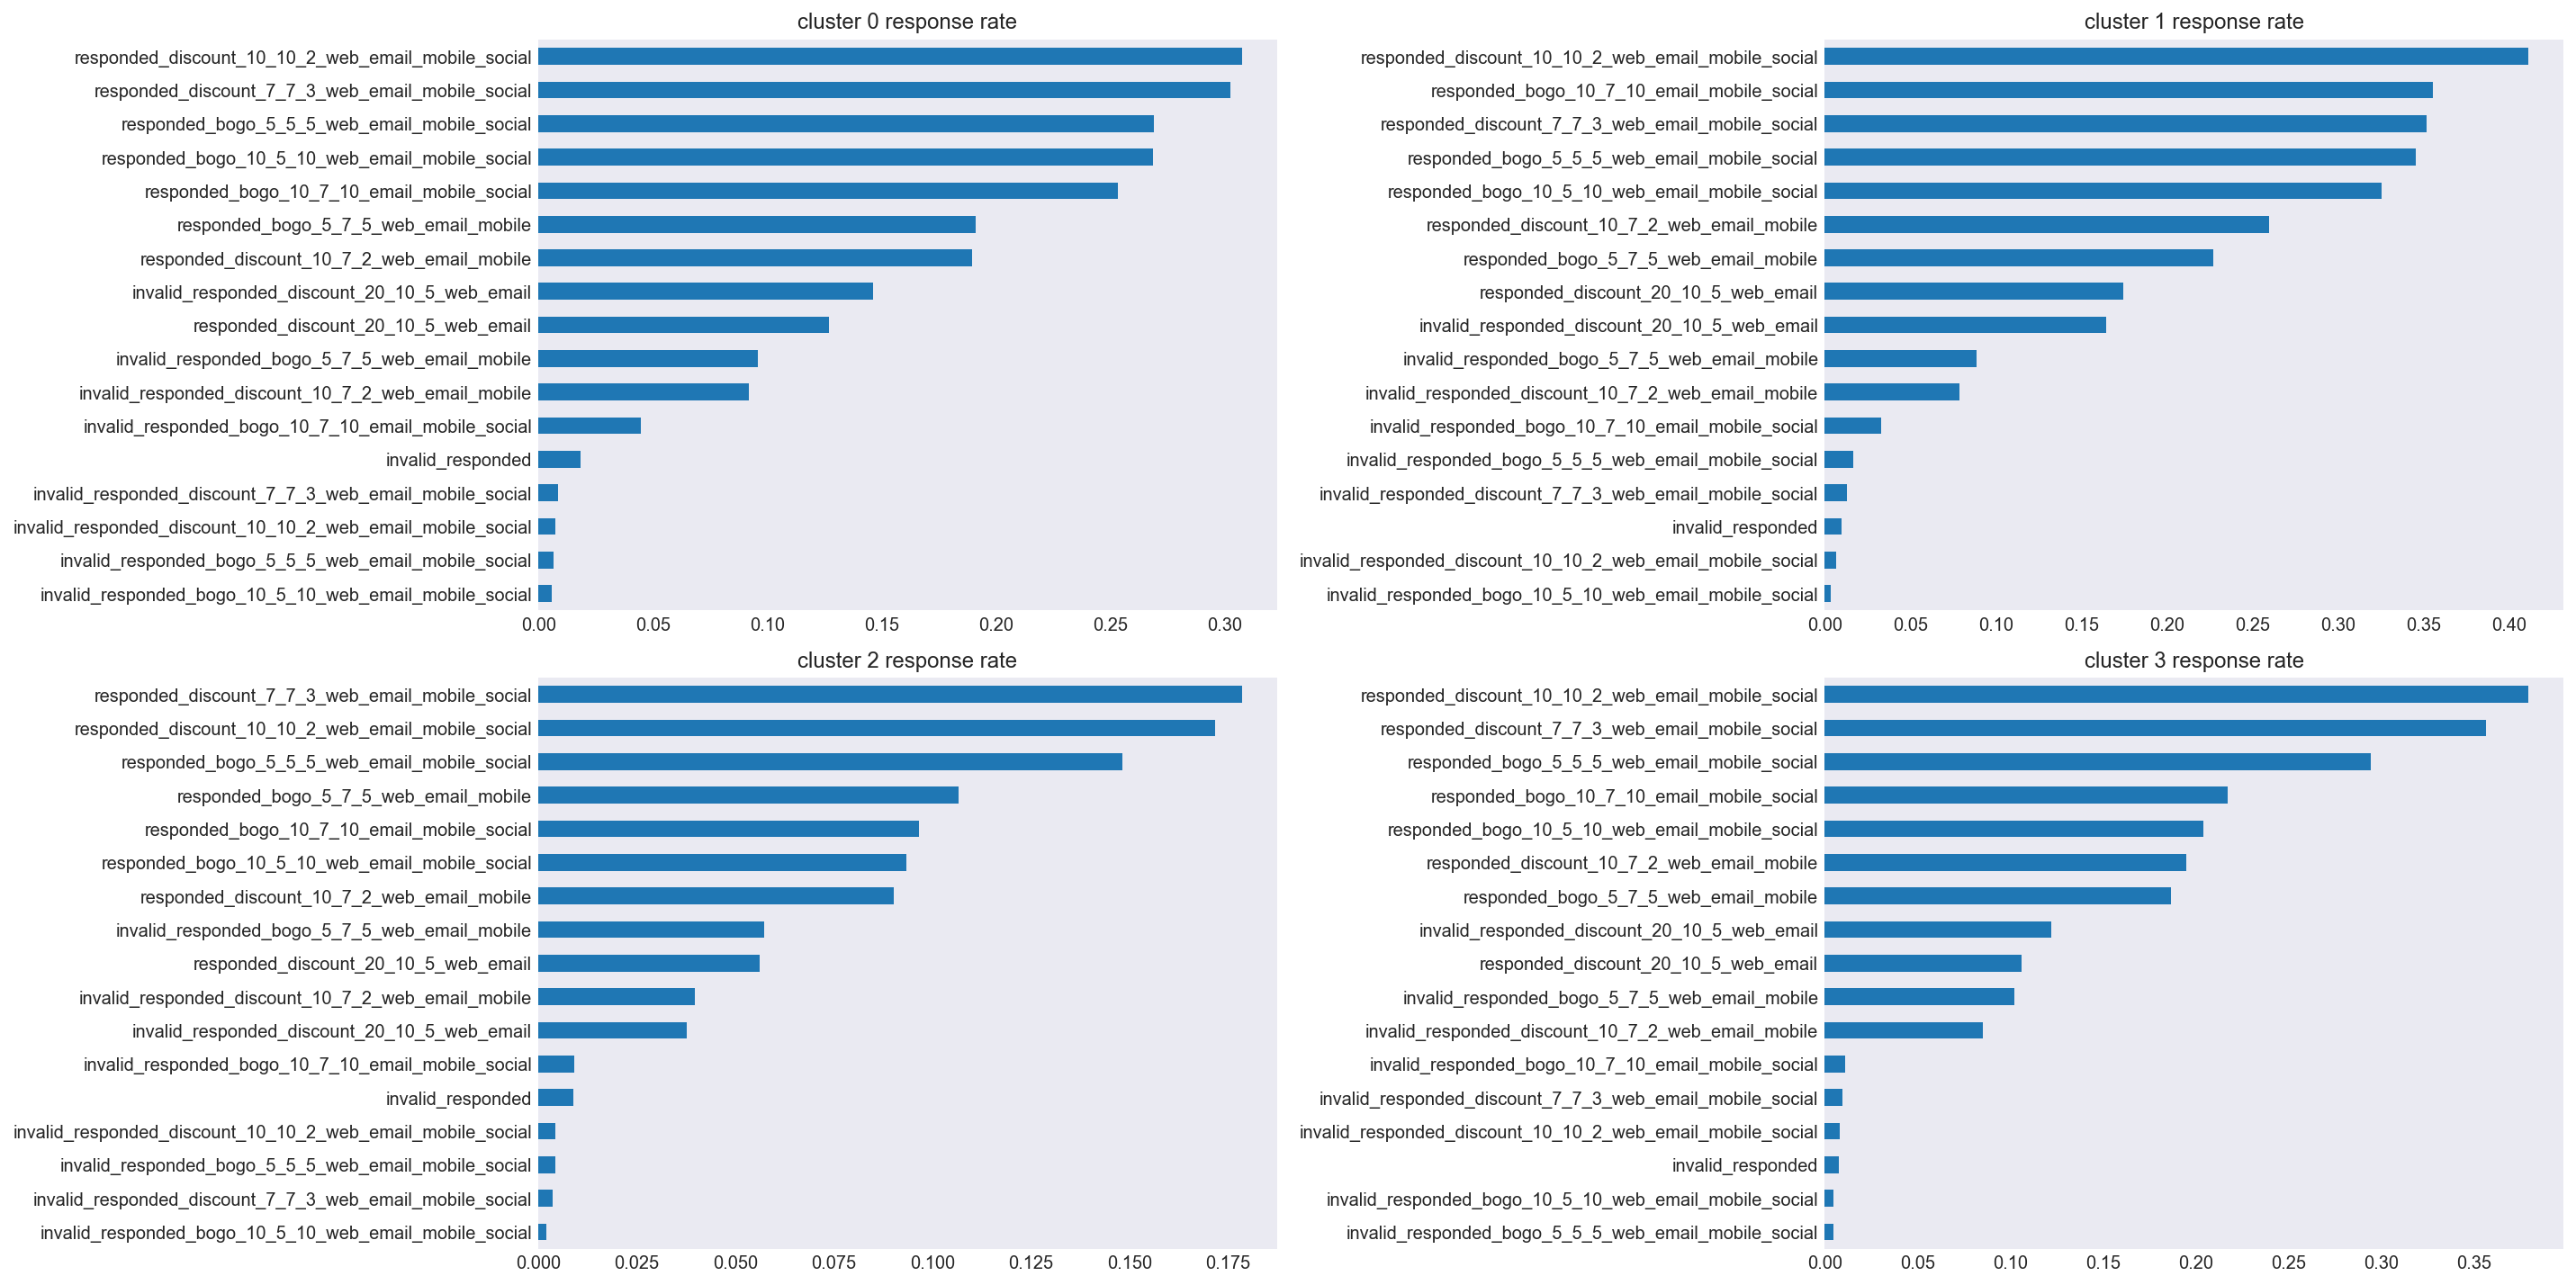

In [89]:
# Plot response rate by clusters to find the popular offer among clusters
def plot_cluster_responses(cluster):
    cluster_responses[cluster].sort_values(ascending=False)[1:].sort_values().plot(kind='barh')
    plt.title(f'cluster {cluster} response rate')

plt.figure(figsize=(20,10))
for cluster in range(4):
    plt.subplot(2,2,cluster+1)
    plot_cluster_responses(cluster)
plt.tight_layout()

# Conclusion
We can send the top responded offer to each cluster. Notice that only for cluster 2, the top responded offer is discount_7_7_3_web_email_mobile_social. This cluster has the lowest age, income, membership period, weekly spending and transactions, etc. All other clusters prefer discount_10_10_2_web_email_mobile_social. 

# cluster characteritics and understanding
cluster 1 is the most active and valuable group of customers, with the highest weekly spending and highest response rate. cluster 2 is the least active with lowest response rate. cluster 0 has the highest age and income, but also has the highest invalid response rate. Lastly, cluster 3 looks like the group of teenagers, with low age and income, but long period of membership and frequent weekly spendings, but low amount spent.

# Build Machine Learning Model to classify customer response to offers

In [32]:
# Examine the ratios of target classes to decide on the classification metrics
print('valid response ratio:')
print(customers.responded.value_counts()/len(customers))

valid response ratio:
1    0.796481
0    0.203519
Name: responded, dtype: float64


In [34]:
customers

,gender,age,id,became_member_on,income,responded,not_responded,invalid_responded,membership_years,weekly_transactions,weekly_amount_spent,cluster
0,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,0,0,1,1.030137,0.75,19.2525,3
1,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0,1.213699,1.75,39.8175,3
2,M,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,1,0,0,0.249315,0.75,14.4325,0
3,M,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,1,0,0,0.457534,0.75,9.1075,0
4,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,1,0,0,0.704110,1.00,3.9050,0
...,...,...,...,...,...,...,...,...,...,...,...,...
14603,F,45.0,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,0,1,0,0.142466,1.75,5.0075,0
14604,M,61.0,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,0,0,1,0.035616,1.75,6.4925,0
14605,M,49.0,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,0,1,0,1.495890,2.00,9.9350,0
14606,F,83.0,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,1,0,0,2.386301,3.50,47.4175,2


In [35]:
# Split customers data into X and y
X = customers[['gender','age','income','membership_years','weekly_transactions','weekly_amount_spent']]

# Convert categorical features into dummy variables
X = pd.get_dummies(X)
X.head()

,age,income,membership_years,weekly_transactions,weekly_amount_spent,gender_F,gender_M
0,55.0,112000.0,1.030137,0.75,19.2525,1,0
1,75.0,100000.0,1.213699,1.75,39.8175,1,0
2,68.0,70000.0,0.249315,0.75,14.4325,0,1
3,65.0,53000.0,0.457534,0.75,9.1075,0,1
4,58.0,51000.0,0.704110,1.00,3.9050,0,1


## Plot ROC curve for model comparison
- We have 3 potential target variables to predict - responded, discount_responded, bogo_responded
- We already have good understandings of the 8 offers regarding response rates and demographics, we don't need to build a model for each offers as it could be biased due to the fact that not every customer received the same offer
- Depending on Starbuck's business objective, we can choose to predict whether the customer will respond to any offer at all; or predict whether the customer will respond to discount or bogo offers

In [36]:
def compare_roc(target):
    '''
    plot ROC for the given target variable - response/invalid response
    '''
    y = customers[target]
    # Set discount_response as the target variable
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train three models
    log_reg = LogisticRegression().fit(X_train, y_train)
    rfc = RandomForestClassifier().fit(X_train, y_train)
    adaboost = AdaBoostClassifier().fit(X_train, y_train)

    # Plot ROC comparisons
    temp = plot_roc_curve(rfc, X_test, y_test)
    plot_roc_curve(adaboost, X_test, y_test, ax=temp.ax_)
    plot_roc_curve(log_reg, X_test, y_test, ax=temp.ax_)
    plt.title(f'ROC for {target}')

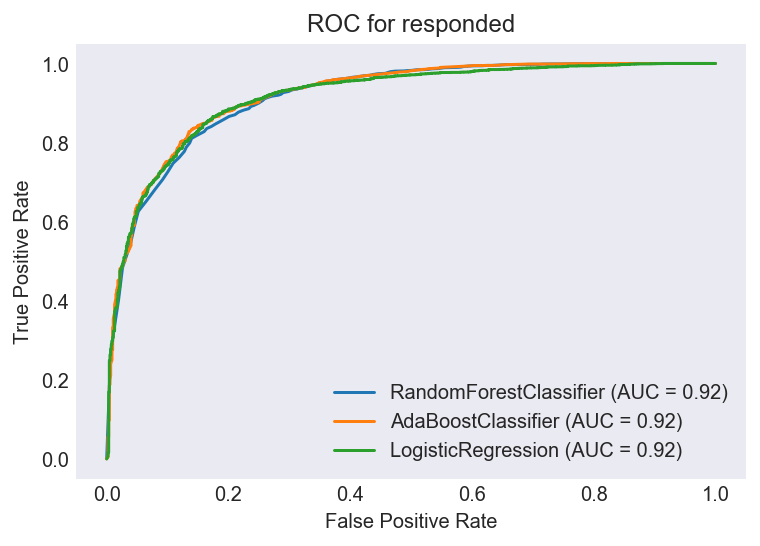

In [39]:
compare_roc('responded')

In [40]:
# Set y as response
y = customers['responded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

parameters = {
    'n_estimators': [10, 30, 50],
    'learning_rate': [0.1, 0.5, 1],
    'algorithm': ['SAMME', 'SAMME.R'],
}

model = GridSearchCV(AdaBoostClassifier(), param_grid=parameters, scoring='f1')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'best parameters: {model.best_params_}')
print(f'f1 score on the testset: {f1_score(y_test, y_pred)}')
print(f'accuracy on the testset: {accuracy_score(y_test, y_pred)}')

best parameters: {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 10}
f1 score on the testset: 0.9288756388415673
accuracy on the testset: 0.8856947296372347


# Conclusion
After extensive EDA and data visualizations, I have come to the conclusion that the demographics for the 3 response groups have similar patterns regardless of offer_types:
- not_responded: customers with the lowest age, lowest income, and lowest days of membership
- invalid_responded: customers with the highest age, highest income, and highest days of membership
- responded: customers with age, income and days of membership in the middle, all slightly less than the invalid_responded group

Firstly, I analyzed demographics for 3 response groups from a macro level - all offers, and found out:
- 74.4 % customers responded to at least 1 offer
- 24.54 % customers did not respond to any offer
- 1.06 % customers completed all received offers without viewing them

Secondly, I analyzed demographics for 3 response groups for discount offers VS bogo offers, and found out:
- discount offers seems to have a slightly higher response rate than bogo offers (63% verses 59%)
- The demographics of discount and bogo response groups are quite similar

Thirdly, I analyzed demographics for 3 response groups for all 8 offers, and found out:
For discount offers:
- The discount offer people love the most is discount_10_10_2, with 70.1% response rate
- The discount offer people love the least is discount_20_10_5, with 23.09% response rate
- This may be due to the fact that the favorable offer has a lower barrier (10 dollars) whereas the least favorable offer has a high minimum spend (20 dollars)
- discount_10_7_2 has a 38% response rate whereas discount_10_10_2 has a 70.1% response rate, this may suggest that an 10-day expiration period gets much more responses than a 7-day expiration period
- In conclusion, people respond better to lower minimum spend and longer expiration days

For BOGO offers:
- The BOGO offer that people love the most is bogo_5_5_5, with a 58.37% response rate
- The BOGO offer that people love the least is bogo_5_7_5, with a 39.4% response rate
- It seems to be a different case for bogo offers, such that with the same conditions, a lower expiration period resulted in higher response rate

Lastly, I built an AdaBoost Machine Learning Model to predict customer response with a 0.92 ROC AUC, 0.94 F1 score and 0.90 accuracy. Because this is an open ended project, it was difficult for me to conclude on a business impact from this model, although it is high performing. Starbucks has many reasons to send out offers, such as promoting a new drink, boosting sales, increasing customer retention and loyalty, etc. If Starbucks wants to increase sales, sending out offers will certainly increase revenue, but not neccessarily profits, unless the promotion has an impact on sales after the promotions which will increase long term profit. 

But why do we bother to predict customer response instead of sending out offers to everyone? There are a number of reasons. First of all, not everyone responds positively to offers, some may dislike them, and it would be a better idea not to send them. Secondly, Starbucks wants to know which of the 8 offers can really excite people, so they can target the right customers with the right offers to ensure best response. Lastly, 1.06% of all customers in the dataset completed the offers without viewing them, which means that they would have spent the same amount of money without the offer. By not sending offers to those customers, Starbucks can save promotion costs associated with the offers. (we know that this 1.06% are people with highest income, highest age, and longest memberships)

# Improvements
This one-month experiment has its limitations. For example, not everyone received the same offers, so we don't know if a certain customer would have responded to another offer, should he/she receive it. Also, not everyone received their first offers at the same time. Although most customers received their first offer at the beginning of the experiment, there are 6 phases where Starbucks sent out first offers to customers. This means a few things: firstly, it is not fair to use offer completion rate as a metric, because every customer got a different number of offers throughout the experiment; secondly, weekly_transactions and weekly_amount_spent should be based on the assumption that all customers are in the same state (with offers or without offers), but the discrepancies in the data can make these 2 metrics biased and not reflect the actual purchasing behaviors of customers. 